# Clase 6: Redes neuronales recurrentes
A partir de un set de señales trigonométricas, se busca predecir 10 muestras a futuro. De manera complementaria, el MSE debe ser menor que el obtenido mediante una red tipo MLP: 0.01488.

## Pruebas realizadas
**Arq. red 1**:
- Hiden size: 20.
- Cant. de layers: 1.
- Fully conected: si.
- Epochs: 5.
- MSE: 0.03801.
  
**Arq. red 2**:
- Hiden size: 20.
- Cant. de layers: 2.
- Fully conected: si.
- Epochs: 5.
- MSE: 0.02677.

**Arq. red 3**:
- Hiden size: 20.
- Cant. de layers: 4.
- Fully conected: si.
- Epochs: 5.
- MSE: 0.01837.


**Arq. red 4 - FINAL**
- Hiden size: 20.
- Cant. de layers: 11.
- Fully conected: si.
- Epochs: 9.
- MSE: 0.0095.

### Librerías

In [1]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error

RANDOM_STATE = 17

### Funciones y clases

In [2]:
# Funcion para generar base de datos de señales
def generate_time_series(batch_size, n_steps, n_future, RANDOM_STATE):
    torch.manual_seed(RANDOM_STATE)
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps + n_future)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    torch.manual_seed(RANDOM_STATE)
    series += 0.1 * (np.random.rand(batch_size, n_steps + n_future) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
# función que plotea un array de curvas (inputs y outputs)
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()


In [4]:
# Clase dataset para luego armar los dataloader
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix]) # si no es train, solo devuelve el X

In [17]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=9):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs+1):
        print("epoch numero: ", epoch)
        bar = tqdm(dataloader['train'])
        model.train()
        train_loss = []
        eval_loss = []
        for batch in bar:
            X, y = batch
            #print(X.shape)
            #input()
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)

            #print('y shape')
            #print(y.shape)
            y = y.view(y.shape[0], -1) # aca elimino la dim de la profundidad
            #print(y.shape)
            #print(' y hat shape')
            #print(y_hat.shape)
            
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            bar.set_description(f"train_loss {np.mean(train_loss):.5f}")
        
        bar = tqdm(dataloader['eval'])
        model.eval()
        
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                y = y.view(y.shape[0], -1)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                bar.set_description(f"valid_loss {np.mean(eval_loss):.5f}")
        
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [18]:
# función para imprimir parametros del modelo.
def imp_param(model):
  print('-'*84)
  print('PARAMETROS DEL MODELO')
  print('-'*84)
  for name, param in model.named_parameters():
    if param.requires_grad: 
      print('Nombre del parámetro: ')
      print(name)
      print('Tamaño del parámetro: ')
      print(param.data.shape)
      print()

### Dataset y dataloader

Se generan los datos y se grafican.

series shape
(10000, 60, 1)
X and y Train shape
(7000, 50, 1) (7000, 10, 1)
X and y Valid shape
(2000, 50, 1) (2000, 10, 1)
X and y Test shape
(1000, 50, 1) (1000, 10, 1)


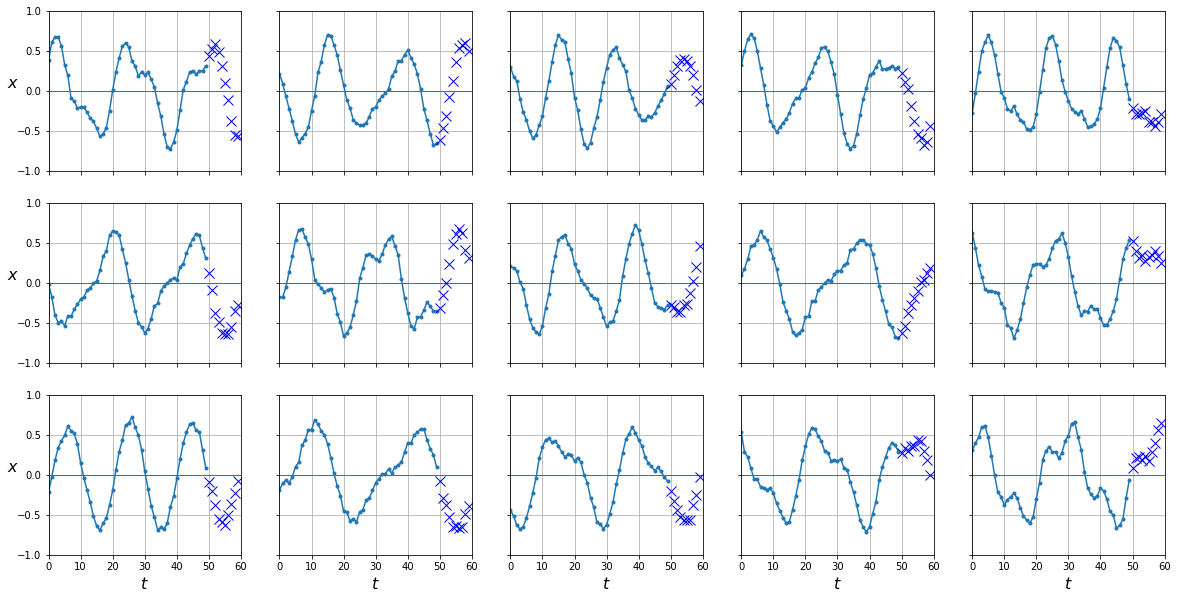

(1000, 10, 1)
(1000, 1, 1)


In [19]:
n_steps = 50
n_future = 10

series = generate_time_series(10000, n_steps, n_future, RANDOM_STATE)
print('series shape')
print(series.shape)

X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

# ploteamos
plot_series(X_test, y_test)
print(y_test.shape)
print(y_test[:,:1,:].shape)

Armados de los set de datos y su configuración para entrenamiento

In [20]:
dataset = {
    'train': TimeSeriesDataset(X_train, y_train[:,:10,:]),
    'eval': TimeSeriesDataset(X_valid, y_valid[:,:10,:]),
    'test': TimeSeriesDataset(X_test, y_test[:,:10,:], train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}
print(type(dataloader))

<class 'dict'>


### Arquitectura de la red

In [21]:
class RNN(torch.nn.Module):
  def __init__(self, input_size=1, hidden_size=20, num_layers=1):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = torch.nn.Linear(20, 10)


    self.fc = torch.nn.Linear(20, 10)

  def forward(self, x):
    x, h = self.rnn(x) 
    # get the last output and apply linear layer
    #print('x shape')
    #print(x.shape)
    #print('x shape [:,-1:]')
    #print(x[:,-1:].shape)
    y = self.fc(x[:,-1])
    
    return y

In [22]:
# Instanciamos el modelo
model_rnn = RNN(input_size=1, hidden_size=20, num_layers=11)

In [23]:
# Verificamos los tamaños de los parámetros de la red
imp_param(model_rnn)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([20, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.weight_ih_l1
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.weight_hh_l1
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l1
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l1
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.weight_ih_l2
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.weight_hh_l2
Tamaño del parámetro: 
torch

In [24]:
# Características de la entrada

torch.manual_seed(0)
entrada = torch.rand(20)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :, None]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([0.4963, 0.7682, 0.0885, 0.1320, 0.3074, 0.6341, 0.4901, 0.8964, 0.4556,
        0.6323, 0.3489, 0.4017, 0.0223, 0.1689, 0.2939, 0.5185, 0.6977, 0.8000,
        0.1610, 0.2823])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 20, 1])

In [25]:
fit(model_rnn, dataloader)

epoch numero:  0


valid_loss 0.04529: 100%|██████████| 32/32 [00:00<00:00, 50.53it/s]


epoch numero:  1


valid_loss 0.02422: 100%|██████████| 32/32 [00:00<00:00, 50.06it/s]


epoch numero:  2


valid_loss 0.02172: 100%|██████████| 32/32 [00:00<00:00, 48.54it/s]


epoch numero:  3


valid_loss 0.01861: 100%|██████████| 32/32 [00:00<00:00, 51.75it/s]


epoch numero:  4


valid_loss 0.01555: 100%|██████████| 32/32 [00:00<00:00, 50.77it/s]


epoch numero:  5


valid_loss 0.01653: 100%|██████████| 32/32 [00:00<00:00, 46.37it/s]


epoch numero:  6


valid_loss 0.01220: 100%|██████████| 32/32 [00:00<00:00, 51.67it/s]


epoch numero:  7


valid_loss 0.01259: 100%|██████████| 32/32 [00:00<00:00, 50.69it/s]


epoch numero:  8


valid_loss 0.01343: 100%|██████████| 32/32 [00:00<00:00, 45.38it/s]


epoch numero:  9


valid_loss 0.00968: 100%|██████████| 32/32 [00:00<00:00, 48.91it/s]


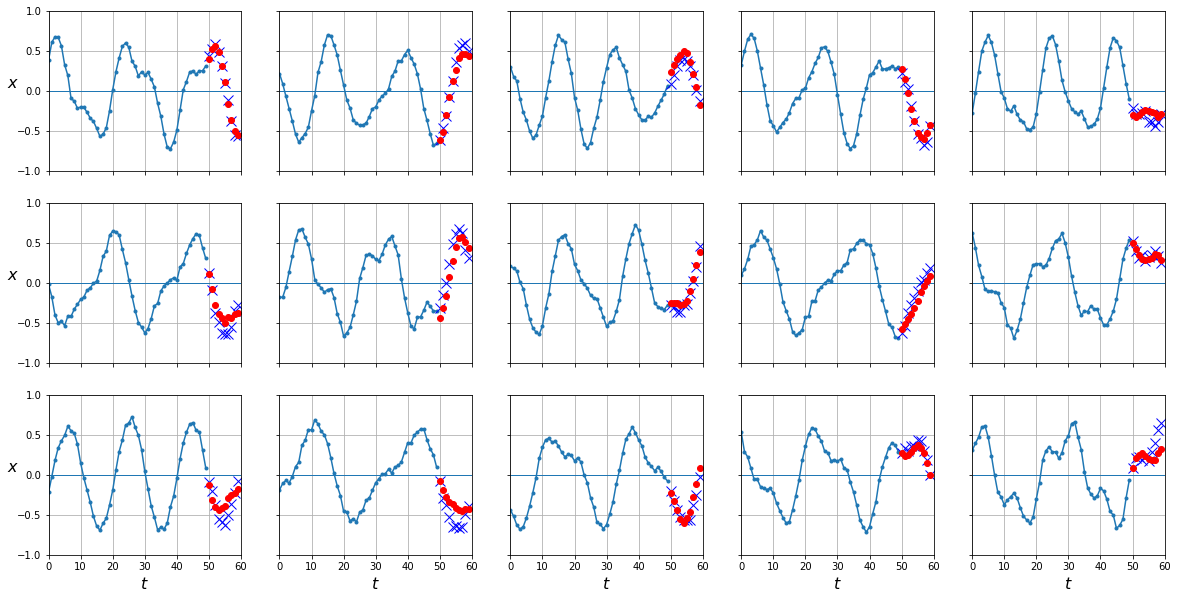

y_test shape:
(1000, 10, 1)
y_pred shape:
torch.Size([1000, 10])
Error cuadratico medio de la estimación final: 


0.0095326295

In [26]:
y_pred = predict(model_rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())


y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred.cpu())